In [5]:
""" Generate data for RTC dataset."""
import os
import cv2
import numpy as np
import ml_collections
from tqdm import tqdm

import jax
from jax import jit
from jax import numpy as jnp
from jwave import FourierSeries
from jwave.utils import load_image_to_numpy
from jwave.acoustics import simulate_wave_propagation
from jwave.geometry import Medium, Domain, TimeAxis

from wavebench import wavebench_dataset_path

jax.default_device = jax.devices("gpu")[1]


thick_lines_data_path = os.path.join(
    wavebench_dataset_path, "time_varying/thick_lines")

config = ml_collections
config.domain_sidelen = 512
config.domain_dx = 2

config.medium_source_loc = (199, 219)
config.medium_density = 2650

config.point_mass_strength = -31000
config.min_wavespeed = 1400
config.max_wavespeed = 4000

config.sigmaX = 200
config.pml_size = 10


domain = Domain(
    (config.domain_sidelen, config.domain_sidelen),
    (config.domain_dx, config.domain_dx))


#  define the properties of the propagation medium
z = np.ones((config.domain_sidelen,config.domain_sidelen))
z[config.medium_source_loc] = config.point_mass_strength

medium_sound_speed = cv2.GaussianBlur(
    z,
    ksize=(0, 0),
    sigmaX=config.sigmaX,
    borderType=cv2.BORDER_REPLICATE)

medium_sound_speed -= medium_sound_speed.min()
medium_sound_speed /= medium_sound_speed.max()

medium_sound_speed = medium_sound_speed*(
  config.max_wavespeed - config.min_wavespeed) + config.min_wavespeed

medium = Medium(domain=domain, sound_speed=medium_sound_speed[..., np.newaxis])
medium.density = config.medium_density
medium.pml_size = config.pml_size

time_axis = TimeAxis.from_medium(medium, cfl=0.3, t_end=0.2)

def sensor_func(p, u, rho):
  return p.on_grid[medium.pml_size, ...].squeeze()

@jit
def get_data_from_sensors(medium, initial_pressure):
  records = simulate_wave_propagation(
      medium, time_axis, p0=initial_pressure, sensors=sensor_func)
  return records


In [7]:

name_list = os.listdir(thick_lines_data_path)
num_data = len(name_list)

# https://vmascagn.web.cern.ch/vmascagn/LABO_2020/numpy-memmap_for_ghost_imaging.html
is_dataset = os.path.join(wavebench_dataset_path, "time_varying/is")

resized_len = config.domain_sidelen//2

# initial_pressure_dataset = np.memmap(
#     f'{is_dataset}/initial_pressure_dataset.npy', mode='w+',
#     shape=(num_data, config.domain_sidelen, config.domain_sidelen),
#            dtype=np.float32)
# boundary_measurement_dataset = np.memmap(
#     f'{is_dataset}/boundary_measurement_dataset.npy', mode='w+',
#     shape=(num_data, int(time_axis.Nt), config.domain_sidelen),
#            dtype=np.float32)

# for (idx, image) in enumerate(tqdm(name_list)):
idx = 0
image = name_list[idx]

image_array = load_image_to_numpy(
    f"{thick_lines_data_path}/{image}",
    image_size=(config.domain_sidelen, config.domain_sidelen))/255
# initial_pressure_dataset[idx, ...] = image_array
# initial_pressure_dataset.flush()
initial_pressure = np.zeros_like(image_array)
resized_img = jax.image.resize(
    image_array,
    (resized_len, resized_len),
    method='bicubic')

initial_pressure[
  :resized_len, resized_len//2: resized_len//2 + resized_len] = resized_img
initial_pressure = jnp.expand_dims(initial_pressure, -1)
initial_pressure = FourierSeries(initial_pressure, domain)

measurements = get_data_from_sensors(medium, initial_pressure)
# boundary_measurement_dataset[idx, ...] = measurements
# boundary_measurement_dataset.flush()

In [9]:
image_array.shape

(512, 512)

## Load saved image datasets

In [1]:
# import numpy as np
# import os
# from wavebench import wavebench_dataset_path
# import matplotlib.pyplot as plt
# rtc_dataset = os.path.join(wavebench_dataset_path, "time_varying/rtc")
# initial_pressure_dataset = np.memmap(
#     f'{rtc_dataset}/initial_pressure_dataset.npy', mode='r',
#     shape=(3000, 512, 512), dtype=np.float32)

# final_pressure_dataset = np.memmap(
#     f'{rtc_dataset}/final_pressure_dataset.npy', mode='r',
#     shape=(3000, 512, 512), dtype=np.float32)


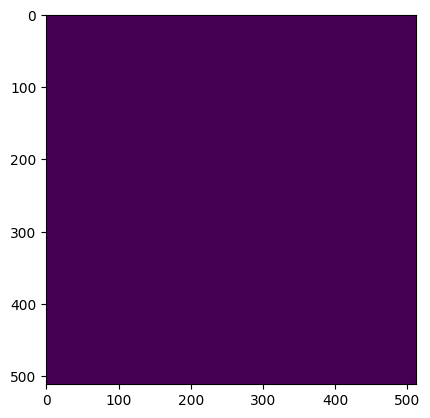

In [12]:
plt.imshow(np.array(final_pressure_dataset)[42] )

In [4]:
np.array(final_pressure_dataset).shape